<p>
This Jupyter notebook investigates a stock market trading algorithm that is described in the
(short) book <i>The 12% Solution: Earn A 12% Average Annual Return On Your Money, Beating
The S&P 500</i> by David Alan Carter.  According to the book this algorithm, which is
 referred to as "ETF rotation", yields a 12% return, on average.
</p>
<p>
This Jupyter notebook is saved on GitHub: https://github.com/IanLKaplan/twelve_percent
</p>
<p>
In this Jupyter notebook I attempt to reproduce the results described in
<i>The 12% solution</i>.
This will verify the results reported in the book and validate this
Python implementation.
</p>
<p>
The book <i>The 12% Solution</i> is targeted at a readership that is not using analytical
tools like Python, Jupyter or R.  Following the proposed algorithm the reader trades one
of four equity ETFs, two bond ETFs or a cash ETF. The analysis of past ETF
performance can be done using on-line tools.
</p>
<p>
<i>The 12% Soluton</p> portfolio allocates 60% of the portfolio for ETF rotation and
40% in bonds.  The bond portion of the portfolio is allocated to either a US Treasury bond
ETF or to a corporate high yield (sometimes called junk bond) ETF, depending on the
relative yield for the previous three months.
</p>
<p>
If the results reported in <i>The 12% solution</i> can be reproduced, it may be possible to
improve on these results.
</p>
<ul>
<li>
The ETFs used in <i>The 12% Solution are highly correlated.  Expanding the universe
of ETFs could improve performance since there may be ETFs that have
better performance in the previous quarter than the four equity ETFs.
</li>
<li>
The algorithm outlines in <i>The 12% solution</i> is referred a momentum algorithm.
Instead of picking the ETF that has the highest return over a three month period,
it would be interesting to examine ETFs that have increased each month over the
three month period (e.g., ETFs that have the highest momentum and return).
</li>
<li>
The performance of the equity ETFs is compared to the "cash" ETF SHY.  If their
performance is worse, the the portfolio is rebalanced into SHY. Investigating
rebalancing into a bond ETF if it's performance is better than SHY and the equity
ETFs should be looked at.
</li>
<li>
The <i>The 12% solution</i> proposes a 60% equity/40% bond allocation in the portfolio.
This reduces volatility, but it also reduces return.  Using an all equity allocation
that rebalances into cash when ETFs have worse than cash performance is something
that would be interesting to look at.
</li>
</ul>

<h2>
The ETF Rotation Set
</h2>
<h3>
Equity ETFs
</h3>
<p>
In <i>The 12% Solution</i> there are four ETFs that are used in rotation, two bond funds
and one ETF (SHY) that is used as a proxy for "cash" (e.g., an asset at the risk free rate).
</p>
<ul>
<li>
<p>
IWM: iShares Russell 2000 ETF
</p>
<p>
IWM tracks a market-cap-weighted index of US small-cap stocks. The index selects
stocks ranked 1,001-3,000 by market cap.
</p>
<p>
Inception date: 5/22/2000
</p>
</li>
<li>
<p>
MDY: SPDR S&P Midcap 400 ETF Trust
</p>
<p>
MDY tracks a market-cap-weighted index of midcap US companies.
</p>
<p>
Inception date: 5/04/1995
</p>
</li>
<li>
<p>
QQQ: Invesco QQQ Trust
</p>
<p>
QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
</p>
<p>
Inception date: 3/10/1999
</p>
</li>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>
<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
</ul>
<h3>
Cash Proxy
</h3>
<ul>
<li>
<p>
SHY: iShares 10-20 Year Treasury Bond ETF
</p>
<p>
SHY tracks a market weighted index of debt issued by the US Treasury
with 1-3 years remaining to maturity. Treasury STRIPS are excluded.
</p>
<p>
Inception date: 07/22/2002
</p>
</li>
</ul>
<p>
In <i>The 12% Solution</i> the back test time period starts January 2008.  The inception period
for the JNK corporate high yield bond fund is November 18, 2007.  This means that a
three month look back period does not exist for this ETF.
</p>

In [7]:
from datetime import datetime, timedelta

import matplotlib
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import pypfopt as pyopt
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import plotting, CLA
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
import numpy as np
from pathlib import Path
import tempfile
import quantstats as qs

def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


plt.style.use('seaborn-whitegrid')

equity_etfs = ['IWM', 'MDY', 'QQQ', 'SPY']
bond_etfs = ['JNK', 'TLT']
cash_etf = 'SHY'

data_source = 'yahoo'
# The start date is the date used in the examples in The 12% Solution
# yyyy-mm-dd
start_date_str = '2008-01-02'
fixed_income_start:datetime = datetime.fromisoformat('2007-12-03')
start_date: datetime = datetime.fromisoformat(start_date_str)
end_date: datetime = datetime.today() - timedelta(days=1)

equity_etf_file = 'equity_etf_close'

etf_close = get_market_data(file_name=equity_etf_file,
                                data_col='Close',
                                symbols=equity_etfs,
                                data_source=data_source,
                                start_date=start_date  - timedelta(days=(365//4)),
                                end_date=end_date)

shy_adjclose_file = 'shy_adjclose'
shy_adj_close = get_market_data(file_name=shy_adjclose_file,
                                data_col='Adj Close',
                                symbols=[cash_etf],
                                data_source=data_source,
                                start_date=start_date - timedelta(days=(365//4)),
                                end_date=end_date)

shy_close_file = 'shy_close'
shy_close = get_market_data(file_name=shy_close_file,
                                data_col='Close',
                                symbols=[cash_etf],
                                data_source=data_source,
                                start_date=start_date - timedelta(days=(365//4)),
                                end_date=end_date)

fixed_income_adjclose_file = "fixed_income_adjclose"
fixed_income_adjclose = get_market_data(file_name=fixed_income_adjclose_file,
                                data_col='Adj Close',
                                symbols=bond_etfs,
                                data_source=data_source,
                                start_date=fixed_income_start,
                                end_date=end_date)

fixed_income_close_file = "fixed_income_close"
fixed_income_close = get_market_data(file_name=fixed_income_close_file,
                                data_col='Close',
                                symbols=bond_etfs,
                                data_source=data_source,
                                start_date=fixed_income_start,
                                end_date=end_date)

corr_mat = round(etf_close.corr(), 3)


<h3>
ETF Correlation
</h3>
<p>
In <i>The 12% Solution</i> ETF rotation the ETF with the highest return in the previous
three months is selected, unless the return is less than the return of SHY, in which case
SHY is selected.
</p>
<p>
One possible problem with this rotation algorith is that the ETFs are highly
correlated. One ETF may do somewhat better than the other ETFs, but they are all
market ETFs and are likely to have similar performance.  If the "market" is down
then all of the ETFs will probably be down.  The ETFs are also likely to have
similar returns.
</p>
<p>
The correlation matrix below shows the correlation between the equity ETFs.
</p>

In [8]:
print(tabulate(corr_mat, headers=[*corr_mat.columns], tablefmt='fancy_grid'))

╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   IWM │   MDY │   QQQ │   SPY │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ IWM │ 1     │ 0.996 │ 0.944 │ 0.979 │
├─────┼───────┼───────┼───────┼───────┤
│ MDY │ 0.996 │ 1     │ 0.942 │ 0.982 │
├─────┼───────┼───────┼───────┼───────┤
│ QQQ │ 0.944 │ 0.942 │ 1     │ 0.983 │
├─────┼───────┼───────┼───────┼───────┤
│ SPY │ 0.979 │ 0.982 │ 0.983 │ 1     │
╘═════╧═══════╧═══════╧═══════╧═══════╛


<p>
The high correlation between the ETFs suggests two areas that are worth investigating:
</p>
<ul>
<li>
<p>
Would the financial performance be similar if only a single ETF were used. For example,
SPY?
</p>
</li>
<li>
<p>
If a larger ETF universe is used ETFs with lower correlation might be selected
resulting in better performance.
</p>
</li>
</ul>

<h3>
Asset return over time
</h3>

<p>
The simple return for a time period <i>t</i> is:
</p>

$\ R_t = \large \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$

The portfolio value calculated via continuously compounded returns is:

$\ portfolio\ value\ = V_t = V_{t-1} + V_{t-1} \times R_{t} $

where $\ V_{0} = initial\ investment $

In [9]:
def findDateIndex(ix: DatetimeIndex, search_date: datetime) -> int:
    index: int = -1
    for i, date in enumerate(ix):
        date_t = date
        if type(date) == str:
            date_t: datetime = datetime.fromisoformat(date)
        if date_t == search_date:
            index = i
            break
    return index

newyears_2008_ix = findDateIndex(etf_close.index, start_date)

assert newyears_2008_ix >= 0

def chooseAsset(start: int, end: int, etf_set: pd.DataFrame, cash: pd.DataFrame) -> pd.DataFrame:
    returns: pd.DataFrame = pd.DataFrame()
    for asset in etf_set.columns:
        t1 = etf_set[asset][start]
        t2 = etf_set[asset][end]
        r = (t2/t1) - 1
        returns[asset] = [r]
    cash_t1 = cash[cash.columns[0]][start]
    cash_t2 = cash[cash.columns[0]][end]
    cash_ret = (cash_t2/cash_t1) - 1
    max_ret = returns.max(axis=1)
    rslt_df = cash
    if float(max_ret) > cash_ret:
        for asset in returns.columns:
            if returns[asset][0] == float(max_ret):
                rslt_df = pd.DataFrame(etf_set[asset])
    return rslt_df

<h3>
Start Period
</h3>

<p>
<i>The 12% Solution</i> ETF rebalancing algorithm picks the ETF with the higest
three month return or SHY (the proxy for cash).  The starting date is the first trading
day in January 2008, Jan 3, 2008. The stock part of the portfolio (60%) is invested
in the chosen asset for the next month and the portfolio is rebalanced again.
</p>
<p>
The 40% of the portfolio that is held in bonds is invested in either TLT (the Treasury
ETF) or JNK (the high yield corporate bond ETF).  However, the inception date of JNK
is November 28, 2007, so there is not sufficient history to calculate a three month return
until March 3, 2008.
</p>

In [10]:
ts_df = chooseAsset(0, newyears_2008_ix, etf_close, shy_adj_close)

print(f'The asset for the first three month period will be {ts_df.columns[0]}')

The asset for the first three month period will be SHY


To check that the code is picking the right asset, we can look at the plot for
the asset close prices.

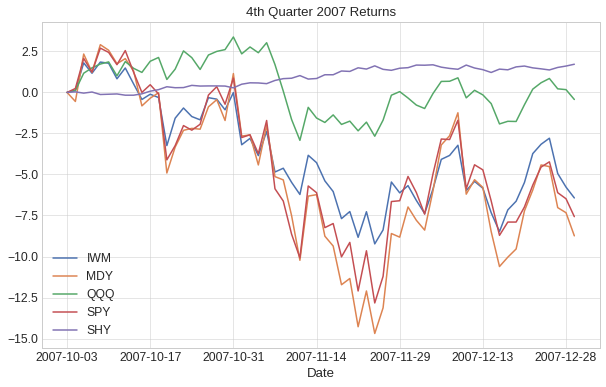

In [11]:
last_quarter:pd.DataFrame = etf_close[:][0:newyears_2008_ix].copy()
last_quarter[shy_adj_close.columns[0]] = shy_adj_close

for col in last_quarter.columns:
    last_quarter[col] = last_quarter[col] - last_quarter[col][0]

last_quarter.plot(grid=True, title='4th Quarter 2007 Returns', figsize=(10,6))

holdings = 100000
equity_percent = 0.6
bonds_percent = 0.4

equity=holdings * equity_percent
bonds=holdings * bonds_percent

trading_days = 252
days_in_quarter = trading_days // 4
days_in_month = trading_days // 12

jnk_start_date_str = "2008-03-03"
jnk_start_date: datetime = datetime.fromisoformat( jnk_start_date_str )

def portfolio_return(start_date: datetime,
                     end_date: datetime,
                     bond_rebalance_start: datetime,
                     look_back_days: int,
                     rebalance_period: int,
                     etf_set: pd.DataFrame,
                     bond_set: pd.DataFrame,
                     bond_default: str) -> pd.Series:
    pass
